# Домашнаяя работа. Функции потерь и оптимизация

Задание:

Реализовать самостоятельно логистическую регрессию
- Обучить ее методом градиентного спуска
- Методом nesterov momentum
- Методом rmsprop

В качестве dataset'а взять Iris, оставив 2 класса:
- Iris Versicolor
- Iris Virginica

## 0. Библиотеки

In [213]:
# Работа с данными
import pandas as pd
import numpy as np

# Датасет
from sklearn import datasets

# Дополнительные фичи
from sklearn.model_selection import train_test_split

# Модели 
from sklearn.linear_model import LogisticRegression

#Визуализации
import seaborn as sns
%matplotlib inline
from jupyterthemes import jtplot
jtplot.style()
import matplotlib.pyplot as plt

## 1. Работа с данными

In [214]:
# Загрузим датасет
dataset = datasets.load_iris()

In [215]:
X = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
Y = pd.DataFrame(dataset.target, columns=['target'])
Y['target_name'] = Y.apply(lambda row: dataset.target_names[row.target], axis=1)
data = pd.concat([X, Y], axis=1)

In [216]:
# Уберем ненужный класс setosa и оставим в датасете тольео Iris Versicolor Iris Virginica
data = data[(data.target_name!='setosa')].reset_index()
X = data.drop(['target', 'target_name'], axis=1)
y = data['target']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [218]:
data.head()

,index,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,50,7.0,3.2,4.7,1.4,1,versicolor
1,51,6.4,3.2,4.5,1.5,1,versicolor
2,52,6.9,3.1,4.9,1.5,1,versicolor
3,53,5.5,2.3,4.0,1.3,1,versicolor
4,54,6.5,2.8,4.6,1.5,1,versicolor


## 2. Модель - Логистическая регрессия с помощью библиотеки sklearn

In [219]:
# Обучение модели из коробки
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [220]:
predictions = model.predict(X_test)
model.score(X_test, y_test)

1.0

In [221]:
# Подобранные коэффициенты для линейной регрессии
model.coef_

array([[ 0.09506532, -1.92040064, -1.53548879,  1.2514556 ,  1.26424529]])

In [222]:
plot_data = pd.concat([X_test, pd.DataFrame(y_test)], axis=1)
plot_data = pd.concat([plot_data.reset_index(drop=True), 
                           pd.DataFrame(predictions, columns=['prediction'])], axis=1)
plot_data.head()

,index,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,prediction
0,76,6.8,2.8,4.8,1.4,1,1
1,136,6.3,3.4,5.6,2.4,2,2
2,52,6.9,3.1,4.9,1.5,1,1
3,105,7.6,3.0,6.6,2.1,2,2
4,125,7.2,3.2,6.0,1.8,2,2


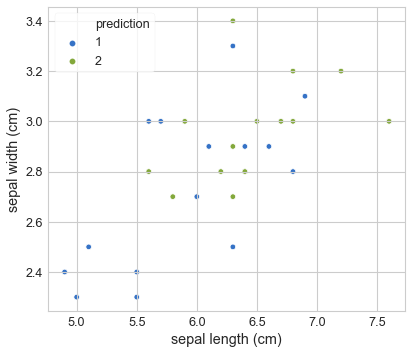

In [223]:
sns.scatterplot(x='sepal length (cm)', y='sepal width (cm)', 
                    hue='prediction', palette=sns.color_palette(n_colors=2), data=plot_data)

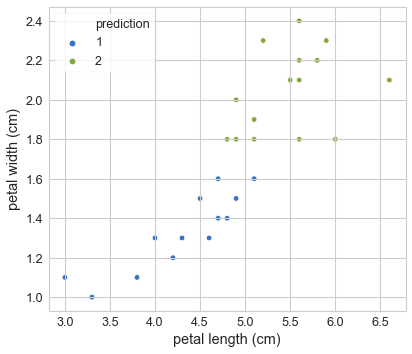

In [224]:
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', 
                    hue='prediction', palette=sns.color_palette(n_colors=2), data=plot_data)

Текущая модель логистической регрессии для Ирисов:

$$h_\theta(x_i) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_3 + \theta_4x_4$$ 
где: 

- $x_1$ - sepal length (cm)
- $x_2$ - sepal width (cm)
- $x_3$ - petal length (cm)
- $x_4$ - petal width (cm)


### 3.1 Метод градиентного спуска

#### Будем использовать Log Loss функцию, которую следует оптимизировать для заданной модели логистической регрессии


$$J(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4) = -\sum_{i=1}^{N} ( y_i\log (h_\theta(x_i)) + (1 - y_i)\log(1 - h_\theta(x_i)) )$$

При этом $h_\theta(x_i)$ можно считать как:
$$h_\theta(x_i) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \theta_3x_3 + \theta_4x_4$$

При этом каждая $\theta$ становится целевым параметром, по которому будет производиться градиентный спуск:

$$\dfrac{d}{d\theta_0}J(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4)=\sum_{i=1}^{m}\log(h_\theta(x^{(i)}) -y^{(i)})$$
$$\dfrac{d}{d\theta_1}J(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4)=\sum_{i=1}^{m}(h_\theta(x^{(i)}) -y^{(i)})x_{1i}$$
$$\dfrac{d}{d\theta_2}J(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4)=\sum_{i=1}^{m}(h_\theta(x^{(i)}) -y^{(i)})x_{2i}$$
$$\dfrac{d}{d\theta_3}J(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4)=\sum_{i=1}^{m}(h_\theta(x^{(i)}) -y^{(i)})x_{3i}$$
$$\dfrac{d}{d\theta_4}J(\theta_0,\theta_1,\theta_2,\theta_3,\theta_4)=\sum_{i=1}^{m}(h_\theta(x^{(i)}) -y^{(i)})x_{4i}$$



In [186]:
X = X_train[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].values.transpose()
y = y_train.values

In [208]:
EPOCHS = 400
LEARNING_RATE = 0.0001

costs = []
preds = []
params = np.random.normal(size=(5,))


for _ in range(EPOCHS):
    predictions = params[0] + params[1] * X[0] + params[2] * X[1] + params[3] * X[2] + params[4] * X[3]
    preds.append(predictions)

    cost = np.sum(np.square(predictions - y)) / (2 * len(predictions))
    costs.append(cost)
    
    params[0] -= LEARNING_RATE * np.sum(predictions - y) / len(predictions)
    params[1] -= LEARNING_RATE * np.sum((predictions - y) * X[0]) / len(predictions)
    params[2] -= LEARNING_RATE * np.sum((predictions - y) * X[1]) / len(predictions)   
    params[3] -= LEARNING_RATE * np.sum((predictions - y) * X[2]) / len(predictions)   
    params[4] -= LEARNING_RATE * np.sum((predictions - y) * X[3]) / len(predictions)       
    
params

array([-0.87807825, -0.37559046,  1.58047447,  0.2071866 , -0.21431429])

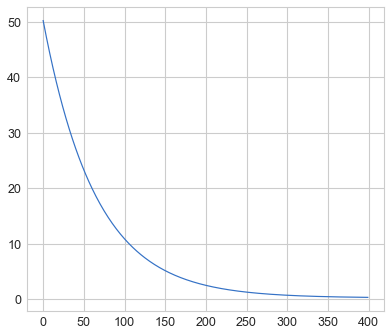

In [209]:
plt.plot(costs)
plt.show()

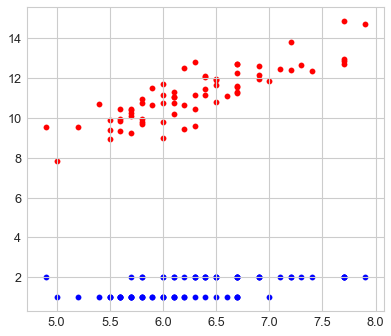

In [212]:
plt.scatter(X[0], y, color='blue')
plt.scatter(X[0], preds[4], color='red')
plt.show()

### 3.2 Метод nesterov momentum

### 3.3 Метод rmsprop